# 🧾 Time Series Analysis – Gray–Scott Reaction–Diffusion

## **1. Objective**
Analyze a real spatiotemporal dataset (Gray–Scott reaction–diffusion) using autocorrelation, ARIMA, Fourier Transform, and Wavelet Transform.

## **2. Load Packages**
Install and import the required Python packages.

In [70]:
# Uncomment and run the following line to install the_well
# !pip install the_well[benchmark]

import matplotlib.pyplot as plt
import numpy as np
import torch
from einops import rearrange
from neuralop.models import FNO
from tqdm import tqdm

from the_well.benchmark.metrics import VRMSE
from the_well.data import WellDataset
from the_well.data.normalization import (  # noqa: F401
    RMSNormalization,
    ZScoreNormalization,
)
from the_well.utils.download import well_download

device = "cuda"
base_path = "/Users/itachi/Desktop" 

## **3. Download Dataset**
Use the tutorial from [The Well GitHub repository](https://github.com/PolymathicAI/the_well/blob/master/docs/tutorials/dataset.ipynb) to load the dataset `gray_scott_reaction_diffusion`.

In [71]:
#well_download(base_path=base_path, dataset="gray_scott_reaction_diffusion", split="train")

In [89]:
dataset = WellDataset(
    well_base_path=f"{base_path}",
    well_dataset_name="gray_scott_reaction_diffusion",
    well_split_name="train",
    n_steps_input=1000,
    n_steps_output=1,
    use_normalization=False,
)

## **4. Select a Random Trajectory**
- The dataset has 120 repetitions.
- Select a random number `n` between 0 and 119.
- Extract the trajectory using:

```python
x = dataset[n]["input_fields"]
```
- Confirm that `x` has shape `(2, 1000, 128, 128)`.

In [90]:


x = dataset[0]["input_fields"]
print(x.shape)

torch.Size([1000, 128, 128, 2])


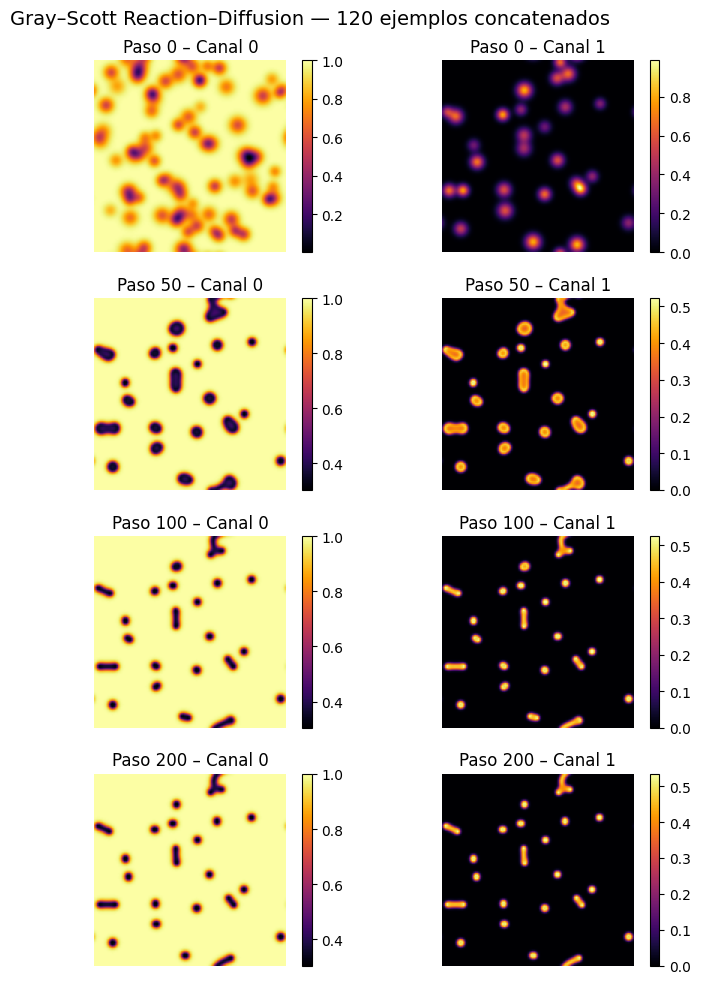

In [91]:
import matplotlib.pyplot as plt
import torch

# Ya tienes esto:
# x_list = [dataset[k]["input_fields"] for k in range(120)]
# x = torch.cat(x_list, dim=0)  # (480, 128, 128, 2)

# Convertir a numpy si es tensor de PyTorch
x = x.cpu().numpy()

# Seleccionamos algunos pasos para visualizar (por ejemplo, los primeros 4)
frames_to_show = [0, 50, 100, 200]  # puedes ajustar esto

fig, axes = plt.subplots(len(frames_to_show), 2, figsize=(8, 10))

for row, t in enumerate(frames_to_show):  # fila ↔ paso temporal
    for c in range(2):  # columna ↔ canal
        im = axes[row, c].imshow(x[t, :, :, c], cmap='inferno')
        axes[row, c].set_title(f"Paso {t} – Canal {c}")
        axes[row, c].axis("off")
        plt.colorbar(im, ax=axes[row, c], fraction=0.046, pad=0.04)

plt.suptitle("Gray–Scott Reaction–Diffusion — 120 ejemplos concatenados", fontsize=14)
plt.tight_layout()
plt.show()

Forma de x: (1000, 128, 128, 2)


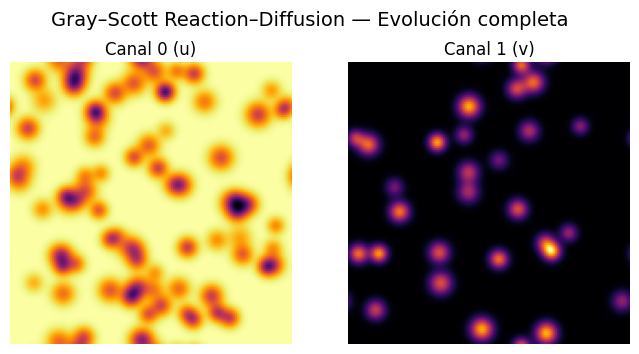

✅ GIF guardado como gray_scott_full.gif


<Figure size 640x480 with 0 Axes>

In [92]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# === Asegurar que x sea un array numpy ===
# (si ya lo es, no hagas nada)
print("Forma de x:", x.shape)  # debería ser (480, 128, 128, 2)

# === Crear la figura con dos paneles (u y v) ===
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
titles = ["Canal 0 (u)", "Canal 1 (v)"]

# Inicializamos las imágenes
ims = []
for c in range(2):
    im = axes[c].imshow(x[0, :, :, c], cmap="inferno", animated=True)
    axes[c].set_title(titles[c])
    axes[c].axis("off")
    ims.append(im)

plt.suptitle("Gray–Scott Reaction–Diffusion — Evolución completa", fontsize=14)

# === Función de actualización para cada frame ===
def update(frame):
    for c in range(2):
        ims[c].set_array(x[frame, :, :, c])
    plt.suptitle(f"Gray–Scott — Frame {frame+1}/{x.shape[0]}", fontsize=14)
    return ims

# === Crear la animación ===
ani = animation.FuncAnimation(
    fig,
    update,
    frames=x.shape[0],   # todos los frames (480)
    interval=80,         # milisegundos entre frames (~12.5 FPS)
    blit=False
)

plt.show()

# === Guardar como GIF (requiere pillow) ===
ani.save("gray_scott_full.gif", writer="pillow", fps=12)
print("✅ GIF guardado como gray_scott_full.gif")

## **5. Extract Random Points**
- Choose **3–5 random spatial points** `(i, j)` in the 128×128 grid.
- For each point, extract the **concentration of A**:

```python
series = x[0, :, i, j]
```
- **Important:** In many cases, the time series will be almost flat and not very interesting.
  Play with different random points until you find curves with visible dynamics or patterns to analyze.
- Plot the time series for each selected point.

65 47


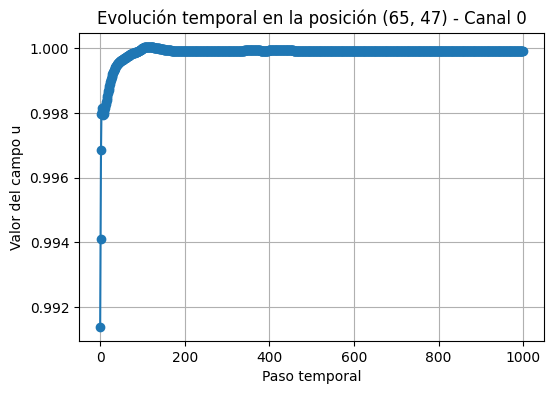

In [93]:


# Elegimos un punto aleatorio del campo espacial
i, j = np.random.randint(0, 127), np.random.randint(0, 127)
print(i,j)
# Extraemos la serie temporal del canal 0 en (i, j)
serie = x[:, i, j, 0]  # dimensión tiempo

# Graficamos la evolución temporal
plt.figure(figsize=(6, 4))
plt.plot(range(len(serie)), serie, marker='o', linestyle='-', color='tab:blue')
plt.title(f"Evolución temporal en la posición ({i}, {j}) - Canal 0")
plt.xlabel("Paso temporal")
plt.ylabel("Valor del campo u")
plt.grid(True)
plt.show()

50 60


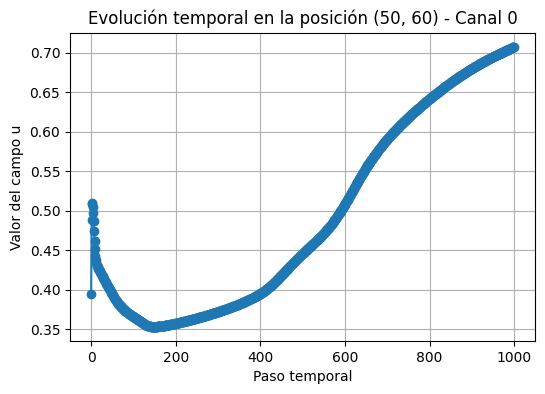

In [94]:
x = dataset[118]["input_fields"].cpu().numpy()  # (4,128,128,2)

# Elegimos un punto aleatorio del campo espacial
i, j = np.random.randint(0, 127), np.random.randint(0, 127)
print(i,j)
# Extraemos la serie temporal del canal 0 en (i, j)
serie = x[:, i, j, 0]  # dimensión tiempo

# Graficamos la evolución temporal
plt.figure(figsize=(6, 4))
plt.plot(range(len(serie)), serie, marker='o', linestyle='-', color='tab:blue')
plt.title(f"Evolución temporal en la posición ({i}, {j}) - Canal 0")
plt.xlabel("Paso temporal")
plt.ylabel("Valor del campo u")
plt.grid(True)
plt.show()

108 57


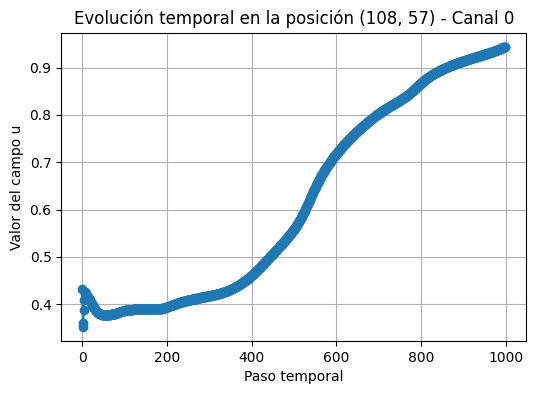

In [95]:
x = dataset[118]["input_fields"].cpu().numpy()  # (4,128,128,2)

# Elegimos un punto aleatorio del campo espacial
i, j = np.random.randint(0, 127), np.random.randint(0, 127)
print(i,j)
# Extraemos la serie temporal del canal 0 en (i, j)
serie = x[:, i, j, 0]  # dimensión tiempo

# Graficamos la evolución temporal
plt.figure(figsize=(6, 4))
plt.plot(range(len(serie)), serie, marker='o', linestyle='-', color='tab:blue')
plt.title(f"Evolución temporal en la posición ({i}, {j}) - Canal 0")
plt.xlabel("Paso temporal")
plt.ylabel("Valor del campo u")
plt.grid(True)
plt.show()

12 4


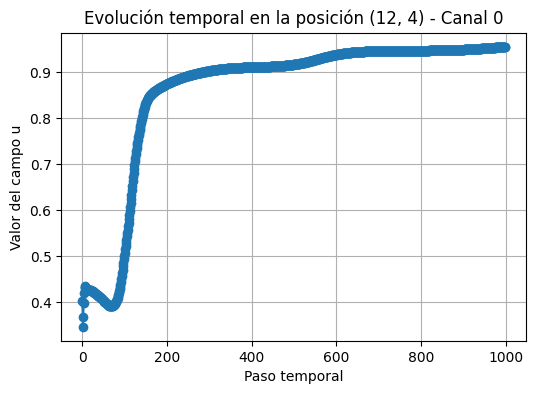

In [96]:
x = dataset[118]["input_fields"].cpu().numpy()  # (4,128,128,2)

# Elegimos un punto aleatorio del campo espacial
i, j = np.random.randint(0, 127), np.random.randint(0, 127)
print(i,j)
# Extraemos la serie temporal del canal 0 en (i, j)
serie = x[:, i, j, 0]  # dimensión tiempo

# Graficamos la evolución temporal
plt.figure(figsize=(6, 4))
plt.plot(range(len(serie)), serie, marker='o', linestyle='-', color='tab:blue')
plt.title(f"Evolución temporal en la posición ({i}, {j}) - Canal 0")
plt.xlabel("Paso temporal")
plt.ylabel("Valor del campo u")
plt.grid(True)
plt.show()

## **6. Autocorrelation Analysis**
- Compute and plot the autocorrelation function for each selected point.
- Interpret whether the signal is strongly correlated over time.

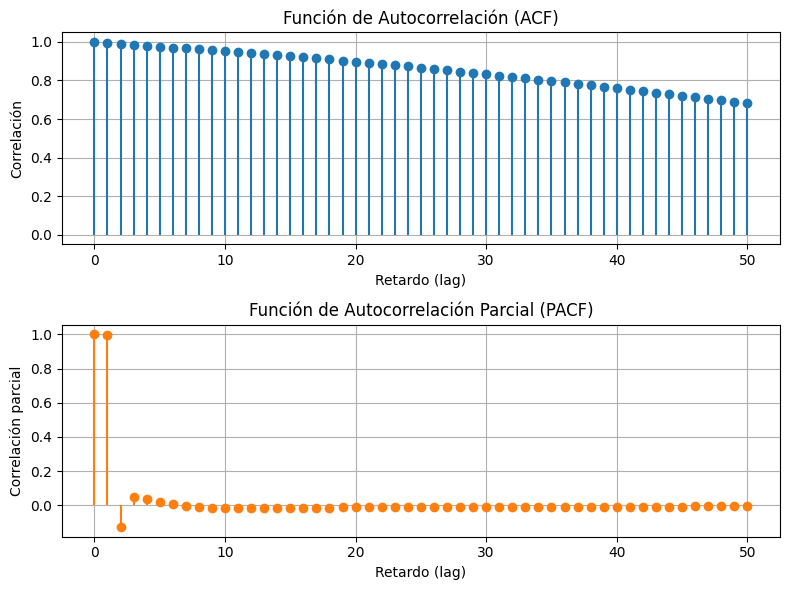

In [ ]:

from statsmodels.tsa.stattools import acf, pacf


# --- Serie temporal ---
serie1 = x[:, 65, 47, 0]
serie2 = x[:, 50, 60, 0]
serie3 = x[:, 108, 57, 0]
serie4 = x[:, 12, 4, 0]

serie1 = np.array(serie1, dtype=float)

# --- Calcular ACF y PACF ---
nlags = min(50, len(serie1) // 2)
acf_vals = acf(serie1, nlags=nlags, fft=True)
pacf_vals = pacf(serie1, nlags=nlags, method="ywmle")

# --- Graficar ---
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
lags = np.arange(len(acf_vals))

# ACF
axes[0].stem(lags, acf_vals, basefmt=" ", linefmt="C0-", markerfmt="C0o")
axes[0].set_title("Función de Autocorrelación (ACF)")
axes[0].set_xlabel("Retardo (lag)")
axes[0].set_ylabel("Correlación")
axes[0].grid(True)

# PACF
axes[1].stem(lags, pacf_vals, basefmt=" ", linefmt="C1-", markerfmt="C1o")
axes[1].set_title("Función de Autocorrelación Parcial (PACF)")
axes[1].set_xlabel("Retardo (lag)")
axes[1].set_ylabel("Correlación parcial")
axes[1].grid(True)

plt.tight_layout()
plt.show()

## **7. ARIMA Modeling**
- Fit an ARIMA model to each time series.
- Compare different `(p, d, q)` orders and choose the best using AIC.
- Plot the original series and fitted values.

📊 Serie (65,47) → mejor modelo ARIMA(1, 0, 3) con AIC = -6982.99
📊 Serie (50,60) → mejor modelo ARIMA(3, 2, 2) con AIC = -10310.52
📊 Serie (108,57) → mejor modelo ARIMA(3, 2, 3) con AIC = -10596.86
📊 Serie (12,4) → mejor modelo ARIMA(2, 2, 2) con AIC = -10139.16


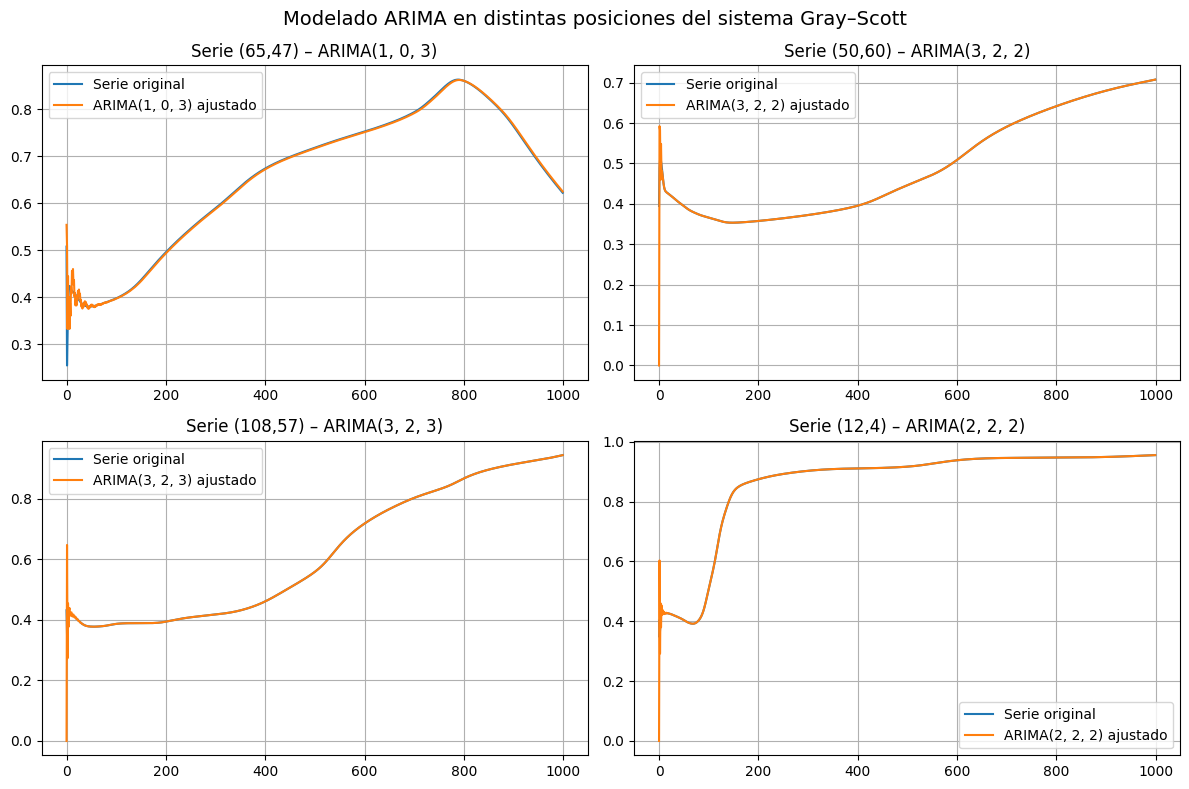

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

# === 1. Extraer las series (ya de x = full_seq o x_total)
serie1 = x[:, 65, 47, 0]
serie2 = x[:, 50, 60, 0]
serie3 = x[:, 108, 57, 0]
serie4 = x[:, 12, 4, 0]

series = [serie1, serie2, serie3, serie4]
labels = ["(65,47)", "(50,60)", "(108,57)", "(12,4)"]

# === 2. Función auxiliar para ajustar ARIMA y devolver resultados ===
def fit_best_arima(series, label, max_p=3, max_d=2, max_q=3):
    best_aic = np.inf
    best_order = None
    best_model = None
    
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(series, order=(p, d, q)).fit()
                    if model.aic < best_aic:
                        best_aic = model.aic
                        best_order = (p, d, q)
                        best_model = model
                except:
                    continue
                    
    print(f"📊 Serie {label} → mejor modelo ARIMA{best_order} con AIC = {best_aic:.2f}")
    return best_model, best_order, best_aic

# === 3. Ajustar modelos para las 4 series ===
results = []
for serie, label in zip(series, labels):
    model, order, aic = fit_best_arima(serie, label)
    results.append((serie, label, model, order))

# === 4. Graficar series y ajustes ===
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, (serie, label, model, order) in enumerate(results):
    ax = axes[i]
    fitted = model.fittedvalues
    ax.plot(serie, label="Serie original", color="tab:blue")
    ax.plot(fitted, label=f"ARIMA{order} ajustado", color="tab:orange")
    ax.set_title(f"Serie {label} – ARIMA{order}")
    ax.legend()
    ax.grid(True)

plt.suptitle("Modelado ARIMA en distintas posiciones del sistema Gray–Scott", fontsize=14)
plt.tight_layout()
plt.show()

## **8. Fourier Transform**
- Apply the FFT to each time series.
- Plot the frequency spectrum.
- Identify dominant frequencies and discuss physical meaning.

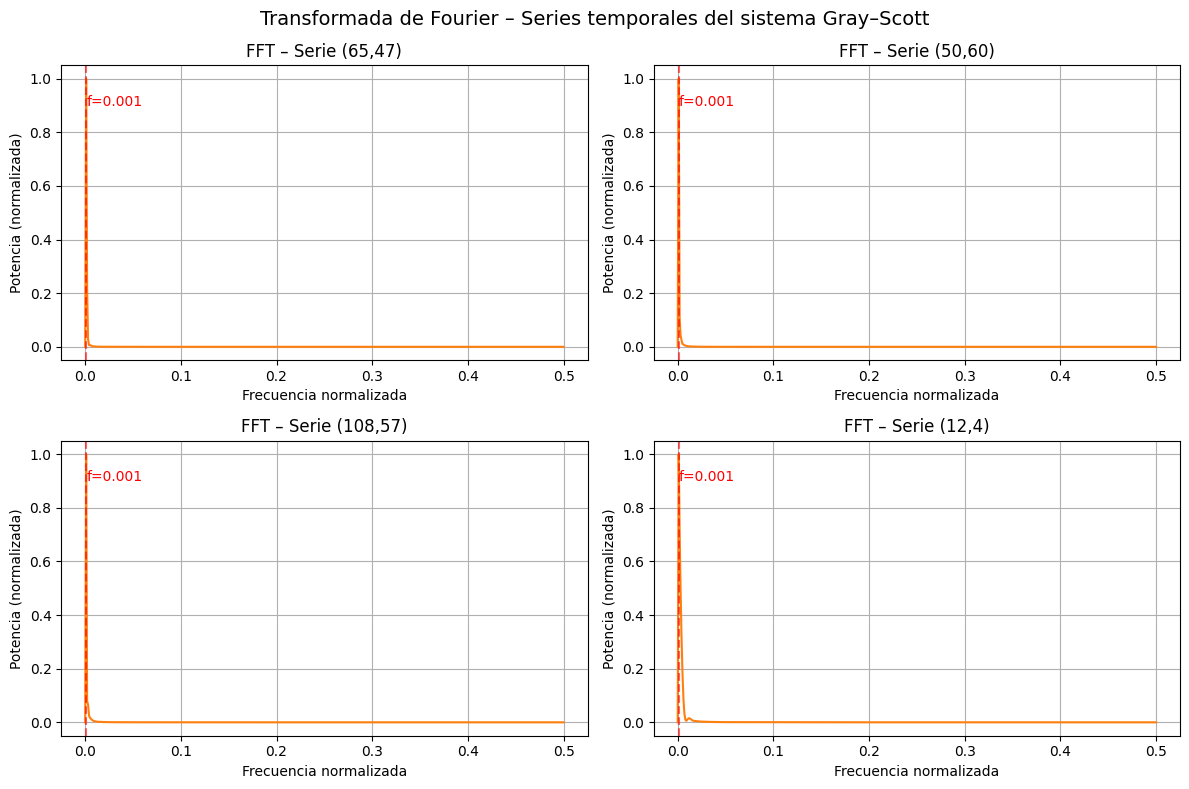

In [ ]:

series = [serie1, serie2, serie3, serie4]
labels = ["(65,47)", "(50,60)", "(108,57)", "(12,4)"]

# === FFT y espectro de potencia ===
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, (serie, label) in enumerate(zip(series, labels)):
    serie = np.array(serie, dtype=float)
    serie -= np.mean(serie)  # eliminar componente DC
    N = len(serie)
    
    # Transformada de Fourier
    fft_vals = np.fft.rfft(serie)
    freqs = np.fft.rfftfreq(N, d=1.0)  # d=1 asume Δt=1 (ajusta si tienes paso temporal distinto)
    
    # Espectro de potencia
    power = np.abs(fft_vals)**2
    
    # Graficar espectro
    axes[i].plot(freqs, power / np.max(power), color="tab:orange")
    axes[i].set_title(f"FFT – Serie {label}")
    axes[i].set_xlabel("Frecuencia normalizada")
    axes[i].set_ylabel("Potencia (normalizada)")
    axes[i].grid(True)
    
    # Identificar frecuencia dominante
    dom_idx = np.argmax(power[1:]) + 1  # ignorar f=0
    dom_freq = freqs[dom_idx]
    axes[i].axvline(dom_freq, color="red", linestyle="--", alpha=0.6)
    axes[i].text(dom_freq, 0.9, f"f={dom_freq:.3f}", color="red")

plt.suptitle("Transformada de Fourier – Series temporales del sistema Gray–Scott", fontsize=14)
plt.tight_layout()
plt.show()

## **9. Wavelet Transform**
- Perform a Continuous Wavelet Transform (CWT) using a Morlet or Complex Morlet wavelet.
- Plot the scalogram.
- Highlight when and where bursts of activity occur.

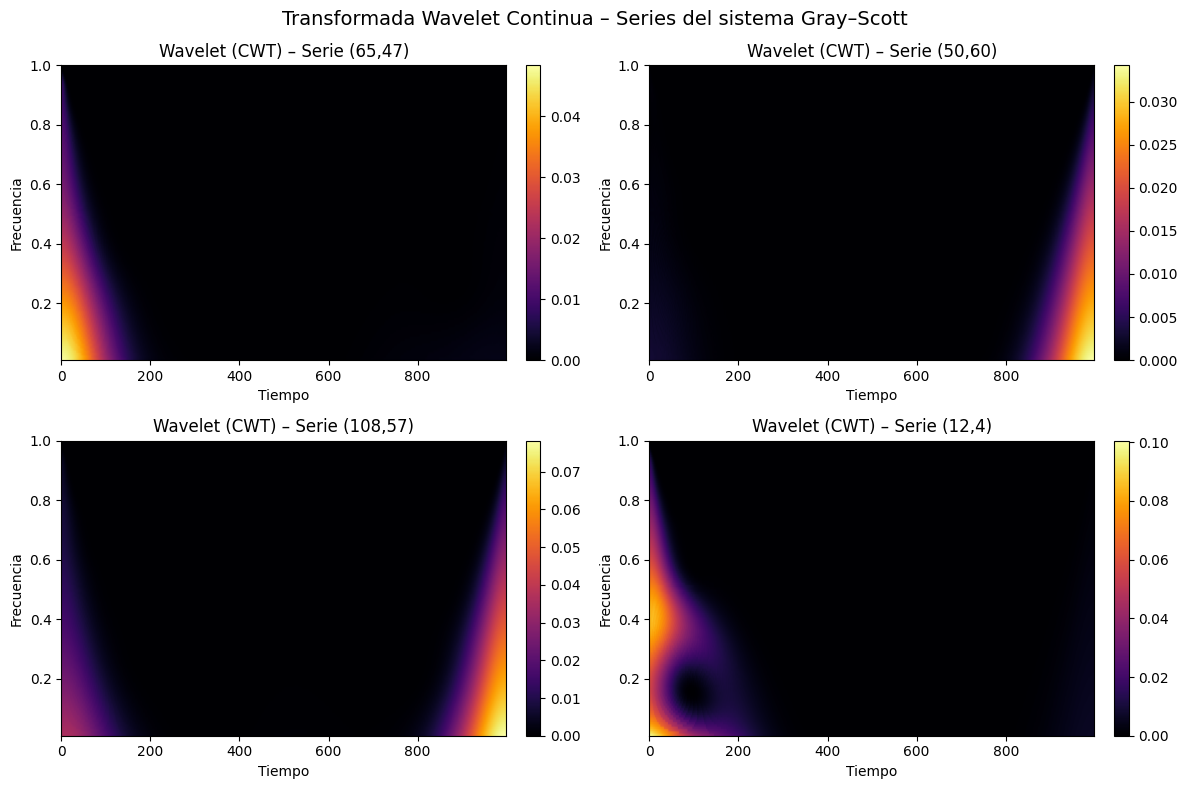

In [106]:

import pywt



series = [serie1, serie2, serie3, serie4]
labels = ["(65,47)", "(50,60)", "(108,57)", "(12,4)"]

# === Parámetros wavelet ===
wavelet = 'cmor1.5-1.0'  # Morlet compleja: cmor(B-C)
scales = np.arange(1, 128)  # escalas: más bajas = frecuencias altas

# === Graficar escalogramas ===
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, (serie, label) in enumerate(zip(series, labels)):
    serie = np.array(serie, dtype=float)
    serie -= np.mean(serie)
    
    # CWT
    coef, freqs = pywt.cwt(serie, scales, wavelet)
    power = np.abs(coef)**2  # espectro de potencia
    
    # Graficar escalograma
    ax = axes[i]
    t = np.arange(len(serie))
    im = ax.imshow(
        power,
        extent=[t[0], t[-1], freqs[-1], freqs[0]],
        aspect='auto',
        cmap='inferno'
    )
    ax.set_title(f"Wavelet (CWT) – Serie {label}")
    ax.set_ylabel("Frecuencia")
    ax.set_xlabel("Tiempo")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle("Transformada Wavelet Continua – Series del sistema Gray–Scott", fontsize=14)
plt.tight_layout()
plt.show()

## **10. Discussion**
- Compare results from different points.
- Discuss differences between high and low concentration regions.
- Suggest physical interpretations of observed patterns.

Comparisons among plots

All the plots exhibit chaotic oscillations dominated by a characteristic frequency around . This suggests that the system evolves on a well-defined intrinsic timescale.

The short “memory” observed—reflected by the rapid decay of autocorrelation—implies that long-term forecasting is inherently unreliable, which explains the poor performance of the ARIMA model.


High and low concentration regions

High concentration regions correspond to moments when a propagating wavefront passes through a specific point. In the CWT, these appear as intense, high-energy bursts localized at the dominant low frequency—representing the active phase of wave propagation.

Low concentration regions represent the quiescent or background state. In the CWT, the strong low-frequency bursts disappear, replaced by weaker high-frequency (low-scale) oscillations. This indicates the decay of a pattern before the onset of a new one.


Physical interpretations

The system possesses a dominant frequency associated with a period of roughly  time units—the characteristic timescale required for a spot to replicate. This defines the fundamental rhythm of pattern formation.

Nonlinear interactions give rise to the observed chaotic behavior. While an isolated wave might evolve in a predictable way, the collisions, mergers, and annihilations between waves introduce strong complexity.

Although localized oscillations may temporarily appear stable, the system is constantly evolving. Any small perturbation can drastically alter the local dynamics, producing distinct spatiotemporal patterns at the sampled points.